In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
from utils import * 

In [2]:
#I remove duration, mid and BPV beacuse of high correaltion with KeyRatioPrice, which has high shap value in previous studies. I do this to reduce statespace.
#Riskspread, KeyRatioDifference, CouponNum, MVal, Yield is also removed to save space

features_statistics = ["Price", "DealersInCompetition", "Spread", "Yield", "Amount", "AllQMeanMid"]
features = ["DealersInCompetition", "Spread", "AllQMeanMid", "FirmAccount", "IssuedAmount", "Oas", "BidAskSpread", "Side", "BookName", "KeyRatioPrice", "inventoryRisk", "bpv_risk"]

# Read the CSV file into a pandas DataFrame
file_path = "data/data_inventory_risk.csv"
df = pd.read_csv(file_path)

In [3]:
def add_direction_column(df):
    df["Direction"] = df["Side"].apply(lambda x: -1 if x == "BUY" else 1)
    df["Direction"] = df["Direction"].astype(float)
    return df

def add_spread_column(df):
    df["Spread"] = df["Direction"] * (df["Price"]-df["Mid"])
    return df

df = add_direction_column(df)
df = add_spread_column(df)

### Basic summary

In [ ]:

nan_count = df['TradedPrice'].isna().sum()
total_rows = len(df)
nan_share = nan_count / total_rows
print("Share of trades with no traded price", round(nan_share,2))


nan_or_zero_counts = df[df["CoverPrice"] == 0 | df['TradedPrice'].isna()]
nan_share = len(nan_or_zero_counts) / total_rows
print("Share of trades with no tagrte price", round(nan_share,2))

Share of trades with no traded price 0.1
Share of trades with no cover price 0.37


count    6256.000000
mean        0.040094
std         0.099374
min        -0.899000
25%         0.011000
50%         0.022000
75%         0.043000
max         3.299000
Name: Spread, dtype: float64
difference betweeen max and min value:  4.1980000000000075
Share of JyskeBank prices on wrong side of mid 0.0879156010230179


<Axes: xlabel='Spread', ylabel='Count'>

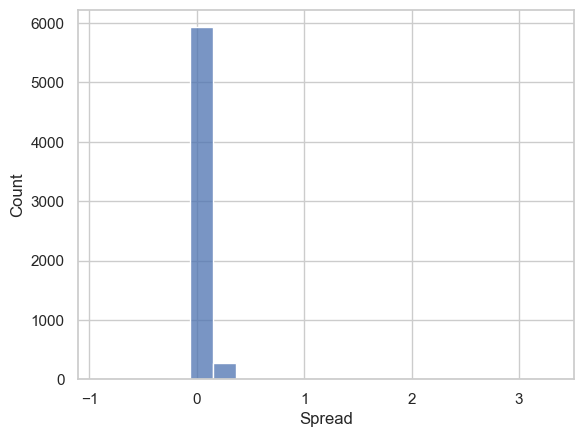

In [92]:
df["Direction"] = df["Side"].apply(lambda x: -1 if x == "BUY" else 1)
df["Direction"] = df["Direction"].astype(float)

# Create actions as spread  independent of the side (using "Direction"). Should I use ALLQ average as mid? 
df["Spread"] = df["Direction"] * (df["Price"]-df["Mid"])

#Look at distribution of actions
print(df.Spread.describe())
print("difference betweeen max and min value: ", np.max(df["Spread"])-np.min(df["Spread"]))
print("Share of JyskeBank prices on wrong side of mid", len(df[df["Spread"] < 0]) / len(df))

sns.set_theme(style="whitegrid")
sns.histplot(df["Spread"], bins=20)


In [93]:
buy_over_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'BUY') & (df["TradedPrice"] > df["Mid"]))
sell_under_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'SELL') & (df["TradedPrice"] < df["Mid"]))
prop = len(df[buy_over_mid | sell_under_mid]) / len(df[df['TradedPrice'] > 0])
print("Share of trades on wrong side of price capture mid", round(prop,3))

buy_over_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'BUY') & (df["TradedPrice"] > df['AllQMeanMid'] + df["Mid"]))
sell_under_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'SELL') & (df["TradedPrice"] < df['AllQMeanMid'] + df["Mid"]))
prop = len(df[buy_over_mid | sell_under_mid]) / len(df[df['TradedPrice'] > 0])
print("Share of trades on wrong side of AllQ mean mid", round(prop, 3))

Share of trades on wrong side of price capture mid 0.312
Share of trades on wrong side of AllQ mean mid 0.343


In [94]:
#Unique number of bonds and clients
unique_count = df['Isin'].nunique() 
print(f'Number of unique values in column ISIN: {unique_count}')

unique_count = df['ClientFirm'].nunique()  
print(f'Number of unique values in column ClientFirm: {unique_count}')

Number of unique values in column ISIN: 182
Number of unique values in column ClientFirm: 40


In [95]:
binaries = ['Result', 'Side', 'BookName']

for feature in binaries:# Calculate value counts
    value_counts = df[feature].value_counts()

    # Calculate total number of observations
    total_observations = len(df)

    # Calculate share of each unique value
    share = value_counts / total_observations

    print(f'{feature} share: {share} \n')

Result share: Result
Lost    0.737212
Won     0.262788
Name: count, dtype: float64 

Side share: Side
SELL    0.597986
BUY     0.402014
Name: count, dtype: float64 

BookName share: BookName
LANGFLEX    0.504316
KORTMM      0.495684
Name: count, dtype: float64 



In [96]:
#Summary of context features
df_statistics = df[features_statistics]

lower_spread_limit = -0.03
upper_spread_limit = 0.15


df_statistics = df_statistics[(df_statistics.Spread > lower_spread_limit) & (df_statistics.Spread < upper_spread_limit)]

print("DataFrame shape:", df_statistics.shape)
#print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df_statistics.describe())

DataFrame shape: (5880, 6)

Summary statistics:
              Price  DealersInCompetition       Spread        Yield  \
count  5880.000000           5880.000000  5880.000000  5880.000000   
mean     97.168022              2.981633     0.028965     3.328448   
std       3.192944              1.335530     0.029063     0.419518   
min      82.020000              1.000000    -0.029000     2.229494   
25%      95.047000              2.000000     0.011000     3.092192   
50%      98.004500              3.000000     0.021000     3.332308   
75%     100.084000              4.000000     0.040000     3.539334   
max     101.493000              9.000000     0.150000    16.636815   

             Amount  AllQMeanMid  
count  5.880000e+03  5880.000000  
mean   2.218015e+07    -0.002144  
std    4.780913e+07     0.029882  
min    1.000000e+03    -0.481400  
25%    1.000000e+06    -0.009400  
50%    4.000000e+06     0.000700  
75%    1.963698e+07     0.009175  
max    5.000000e+08     0.231300  


In [97]:
df_margins = calculate_margins(df)
nan_count = df_margins['TargetPrice'].isna().sum()
total_rows = len(df_margins)
nan_share = nan_count / total_rows
print("Share of trades with no target price", round(nan_share,2))

Share of trades with no target price 0.1


In [98]:
#How is the distribution of ISINS
isinCount = df.Isin.value_counts()
print(isinCount)

Isin
DK0009507931    253
DK0009515363    245
DK0009296469    226
DK0009295149    216
DK0009295222    198
               ... 
DK0004625001      1
DK0004617255      1
DK0009537920      1
DK0009522146      1
DK0009410938      1
Name: count, Length: 182, dtype: int64


In [99]:
#Summary of context features. Before spread clamping
df = df[features]
print("DataFrame shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe())


DataFrame shape: (6256, 12)

Column names:
 Index(['DealersInCompetition', 'Spread', 'AllQMeanMid', 'FirmAccount',
       'IssuedAmount', 'Oas', 'BidAskSpread', 'Side', 'BookName',
       'KeyRatioPrice', 'inventoryRisk', 'bpv_risk'],
      dtype='object')

Data types:
 DealersInCompetition      int64
Spread                  float64
AllQMeanMid             float64
FirmAccount              object
IssuedAmount            float64
Oas                     float64
BidAskSpread            float64
Side                     object
BookName                 object
KeyRatioPrice           float64
inventoryRisk           float64
bpv_risk                float64
dtype: object

Summary statistics:
        DealersInCompetition       Spread  AllQMeanMid  IssuedAmount  \
count           6256.000000  6256.000000  6256.000000  6.233000e+03   
mean               2.990090     0.040094    -0.002148  2.135285e+10   
std                1.322944     0.099374     0.039133  1.103036e+10   
min                1.0000

In [100]:
#After clamping
df = df[(df.Spread > lower_spread_limit) & (df.Spread < upper_spread_limit)]
print("DataFrame shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe())

DataFrame shape: (5880, 12)

Column names:
 Index(['DealersInCompetition', 'Spread', 'AllQMeanMid', 'FirmAccount',
       'IssuedAmount', 'Oas', 'BidAskSpread', 'Side', 'BookName',
       'KeyRatioPrice', 'inventoryRisk', 'bpv_risk'],
      dtype='object')

Data types:
 DealersInCompetition      int64
Spread                  float64
AllQMeanMid             float64
FirmAccount              object
IssuedAmount            float64
Oas                     float64
BidAskSpread            float64
Side                     object
BookName                 object
KeyRatioPrice           float64
inventoryRisk           float64
bpv_risk                float64
dtype: object

Summary statistics:
        DealersInCompetition       Spread  AllQMeanMid  IssuedAmount  \
count           5880.000000  5880.000000  5880.000000  5.857000e+03   
mean               2.981633     0.028965    -0.002144  2.146862e+10   
std                1.335530     0.029063     0.029882  1.096377e+10   
min                1.0000

In [101]:
missing_values = df.isnull().sum()
print("\nMissing values:\n", missing_values)
df = df.dropna()



Missing values:
 DealersInCompetition     0
Spread                   0
AllQMeanMid              0
FirmAccount              0
IssuedAmount            23
Oas                      0
BidAskSpread             0
Side                     0
BookName                 0
KeyRatioPrice            0
inventoryRisk            0
bpv_risk                 0
dtype: int64


### Numeric features exploration

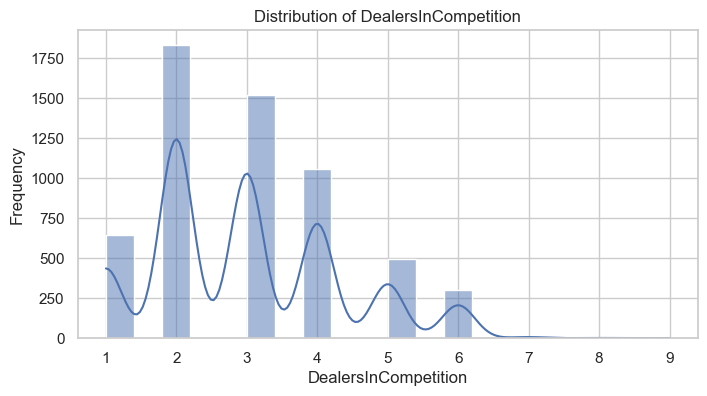

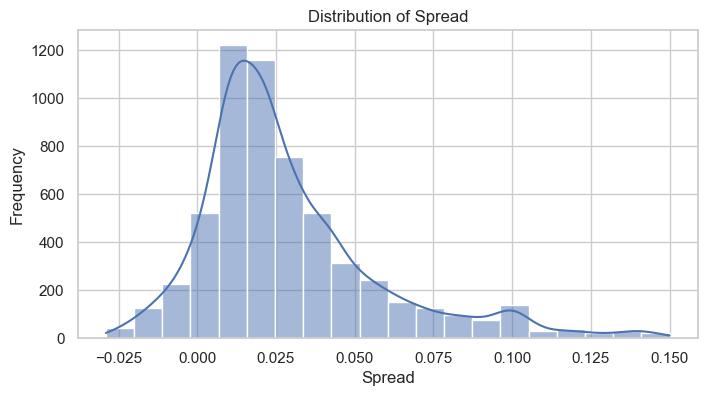

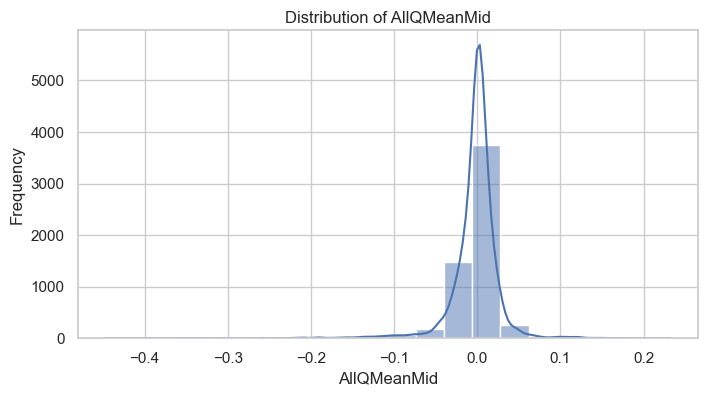

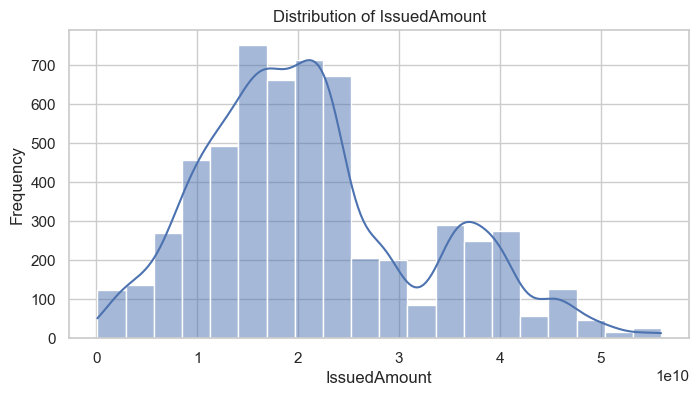

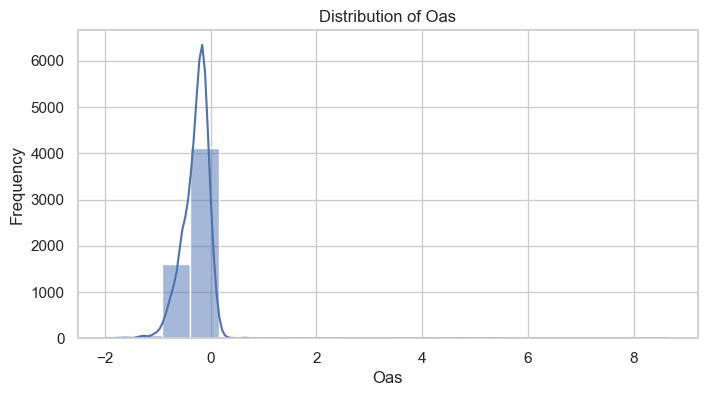

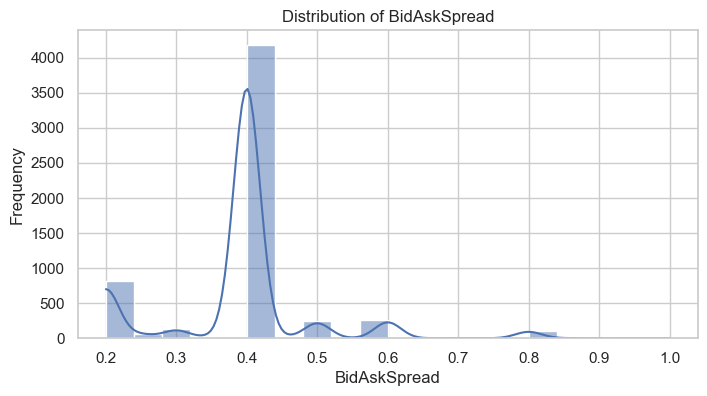

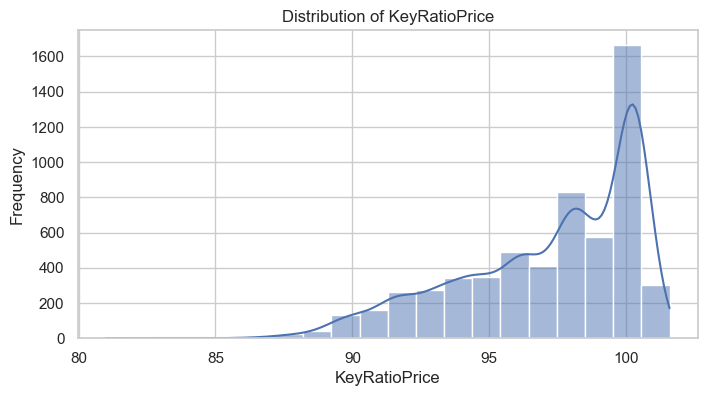

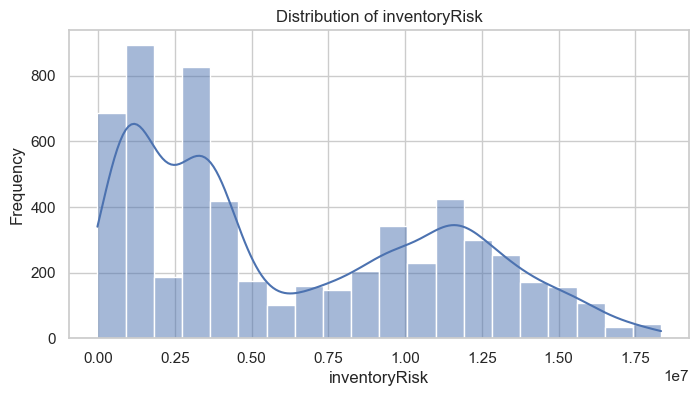

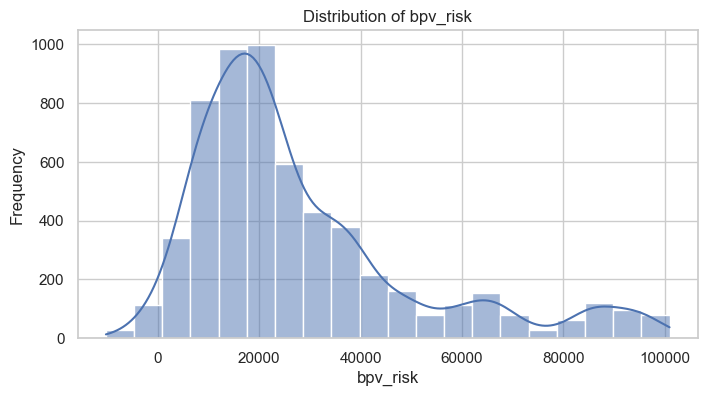

In [102]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


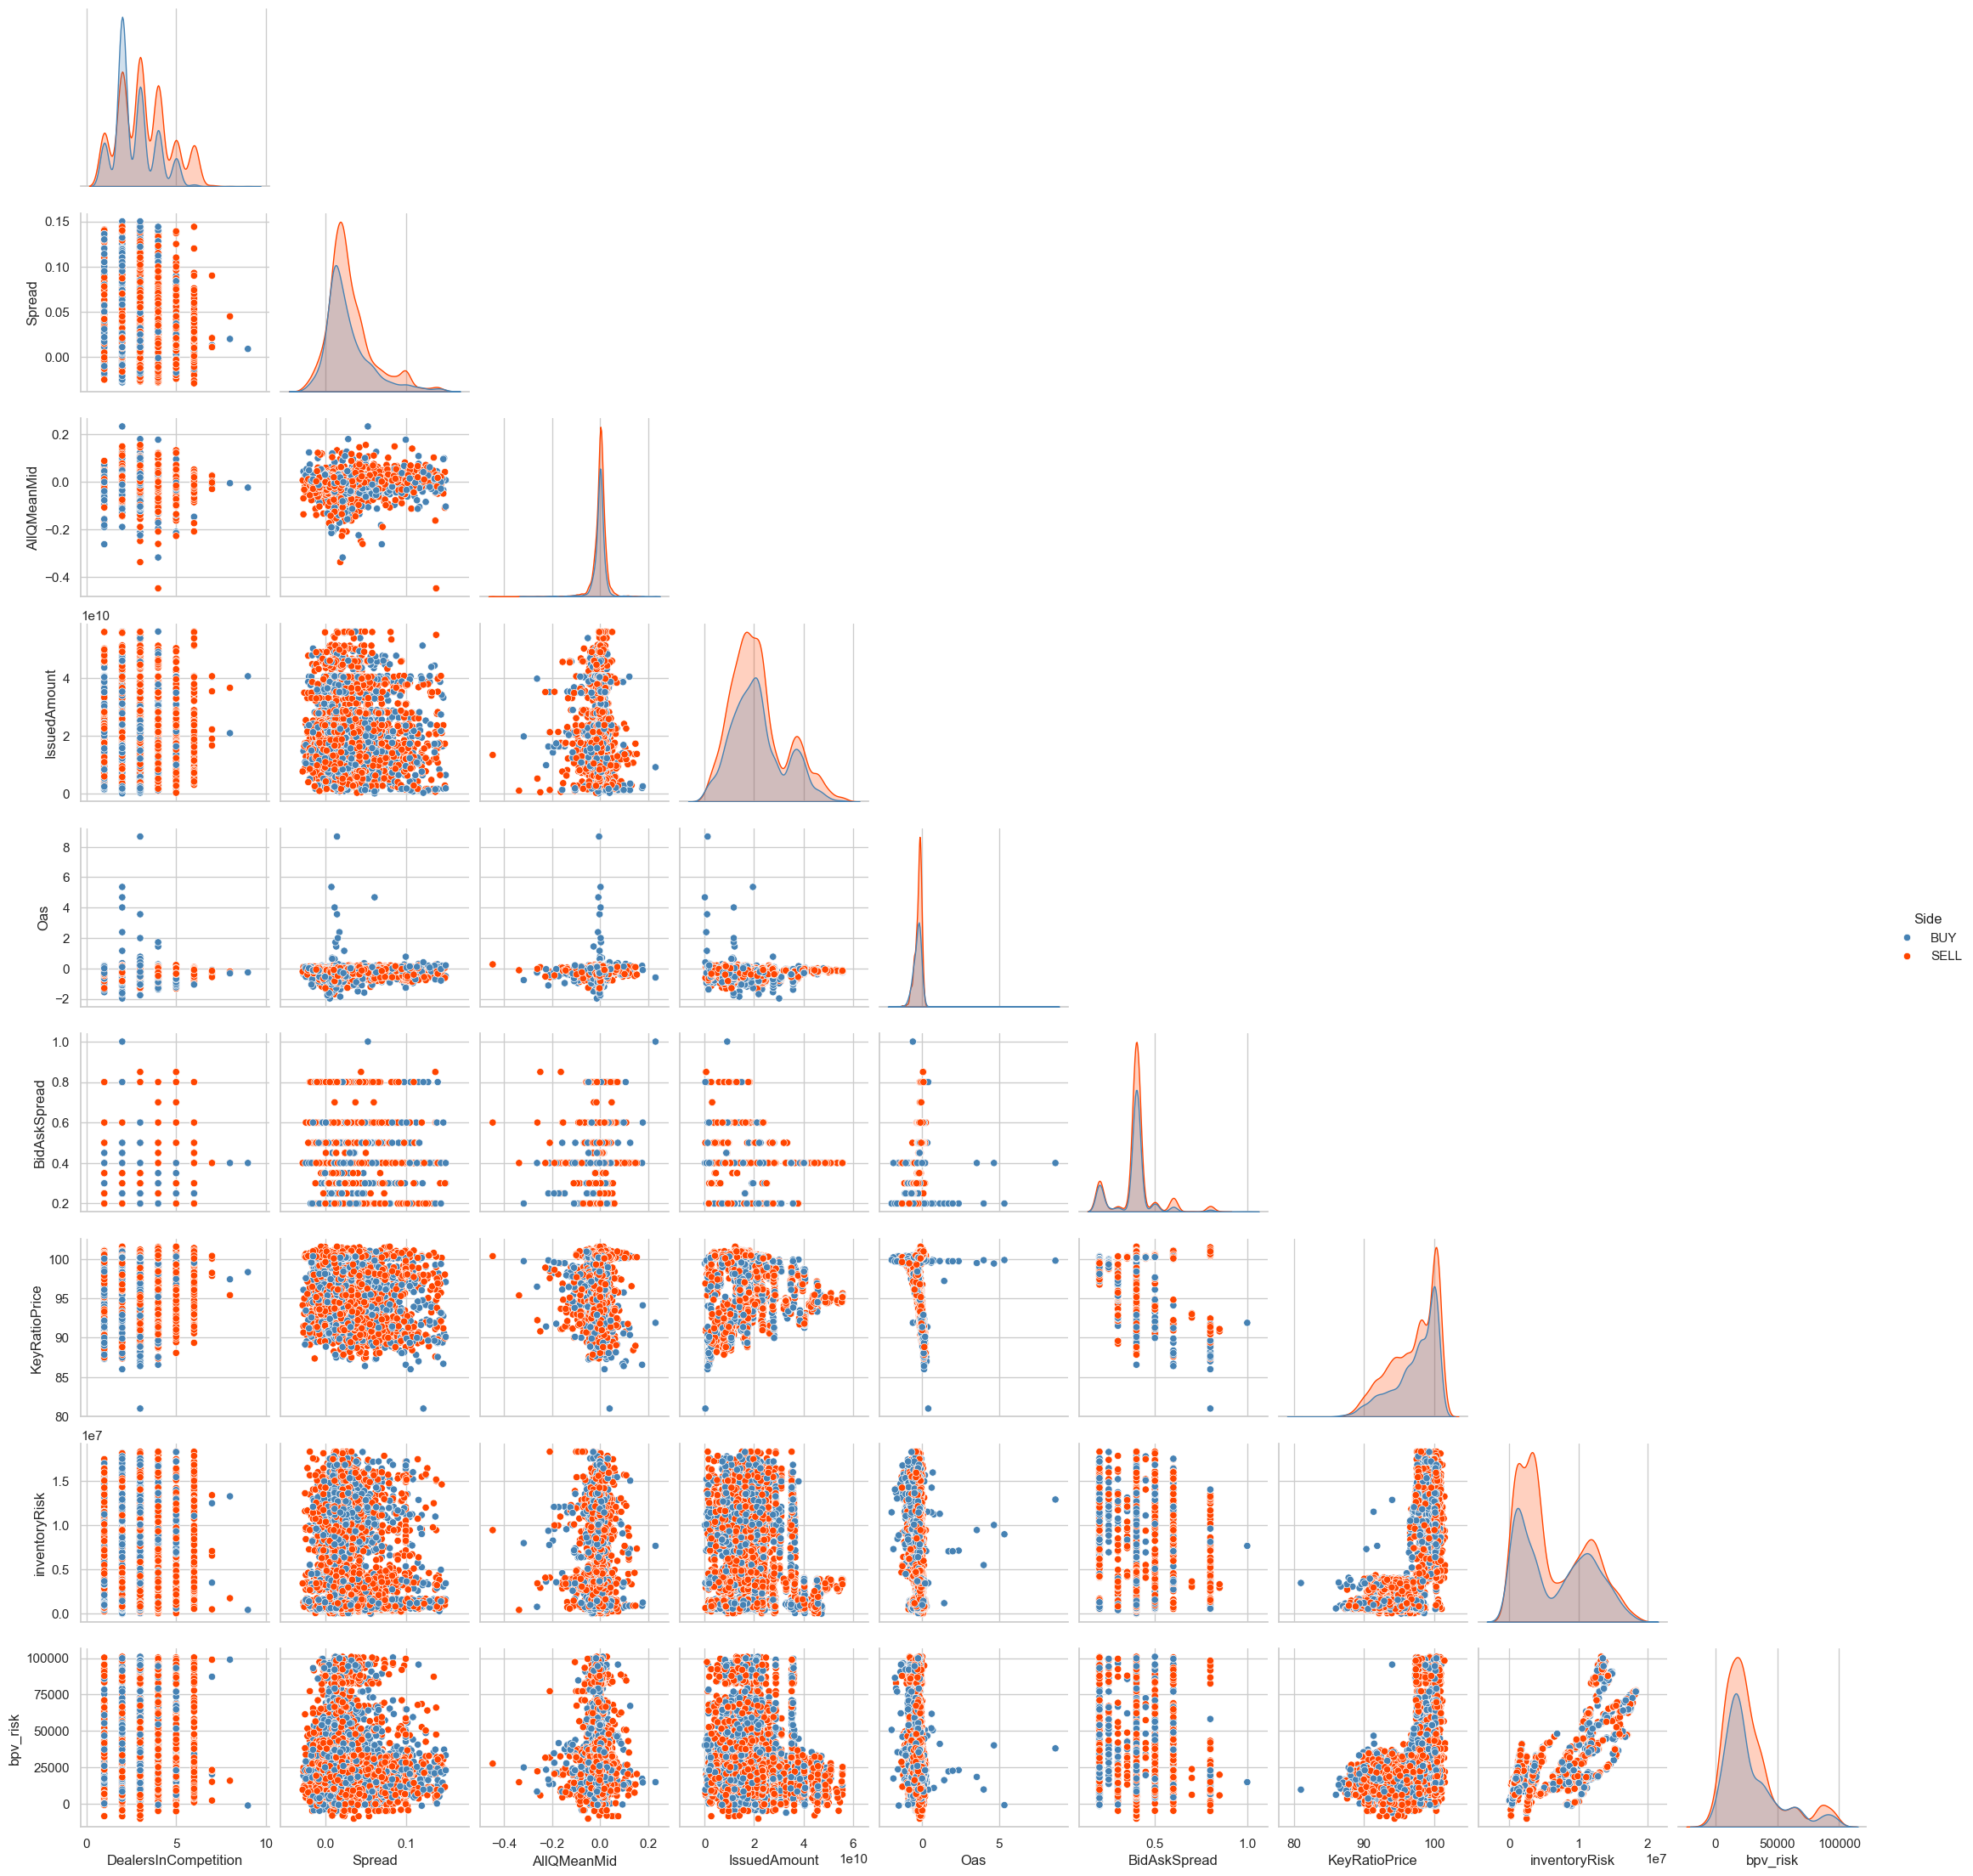

In [103]:
numeric_columns_and_side = numeric_columns.tolist()
numeric_columns_and_side.append('Side')
custom_palette = ['steelblue', 'orangered']

sns.pairplot(df[numeric_columns_and_side], hue='Side', corner=True, palette=custom_palette)
plt.show()

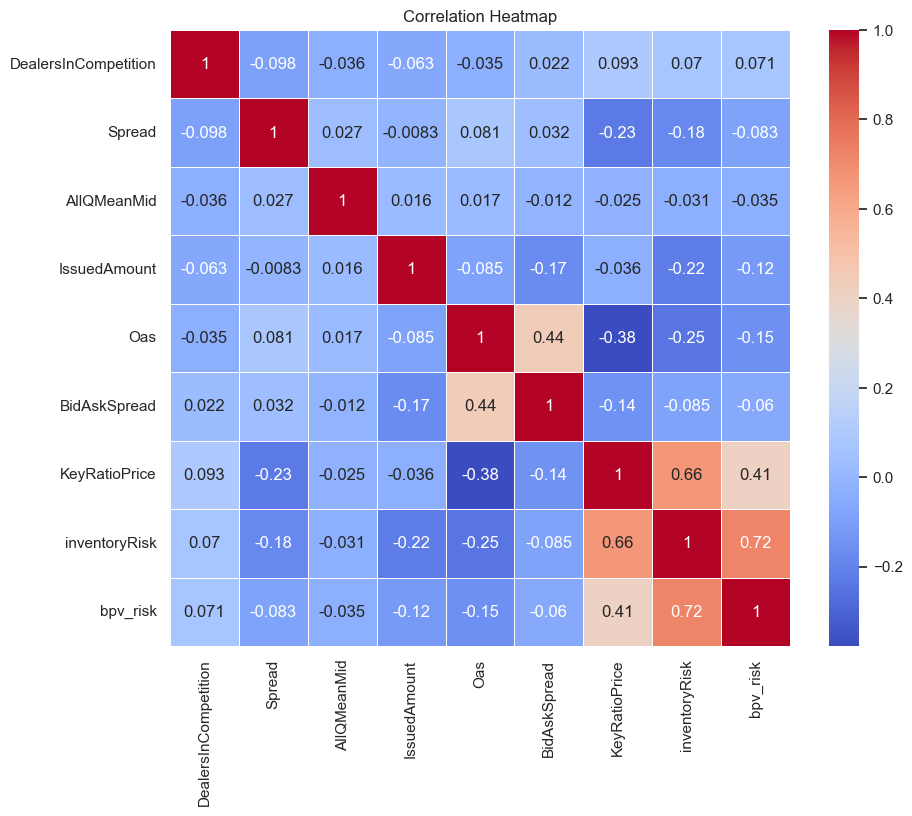

In [104]:
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Categorical features exploration

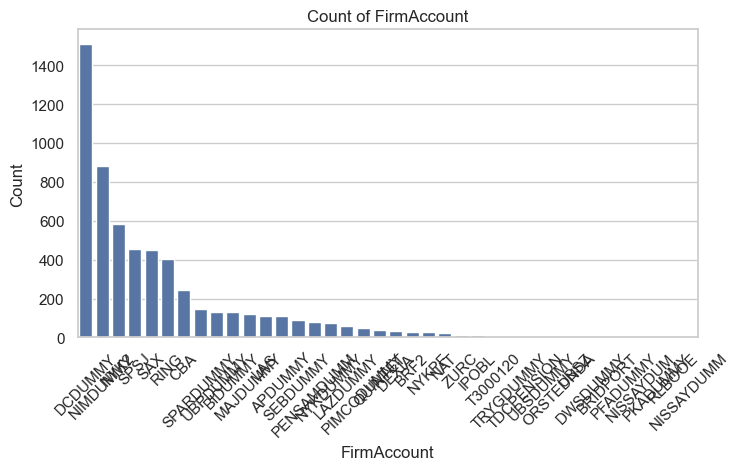

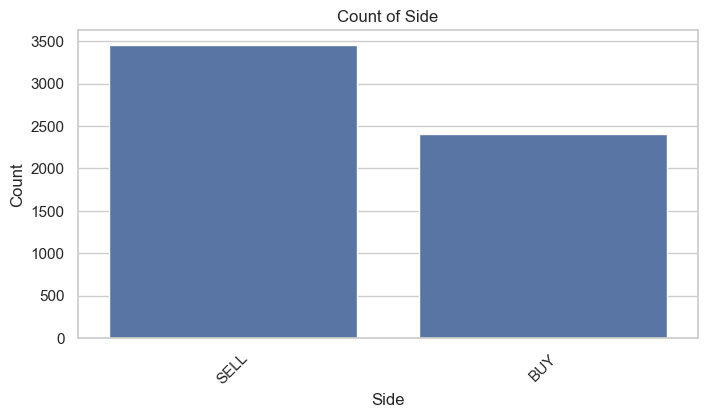

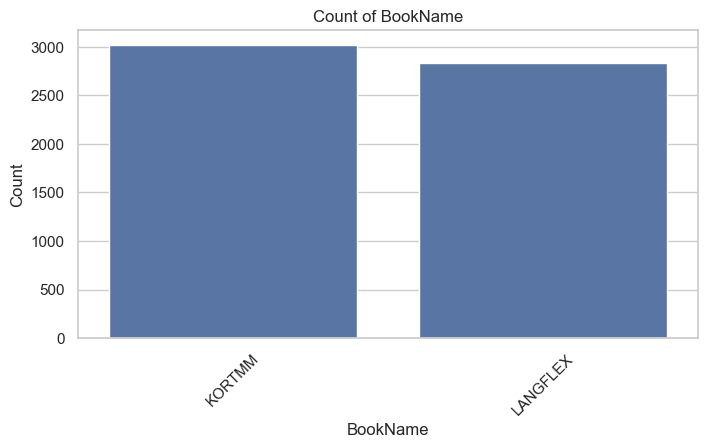

In [105]:
categorical_columns = df.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


### Group FirmAccounts which has small frequency into other group

In [106]:
df['FirmAccount'].value_counts(normalize=True)

FirmAccount
DCDUMMY       0.257640
NIMDUMMY      0.150418
NYK2          0.099710
SPSJ          0.077514
SAX           0.076660
RING          0.068636
CBA           0.042001
SPARDUMMY     0.024757
UBPDUMMY      0.022708
BIDUMMY       0.022537
MAJDUMMY      0.020659
LAS           0.019122
APDUMMY       0.018439
SEBDUMMY      0.015366
PENSAMDUMM    0.013317
NYKDUMMY      0.012634
LAZDUMMY      0.010244
PIMCODUMMY    0.008708
QUINTET       0.006488
DEXIA         0.005634
BRF2          0.005122
NYKPF         0.004781
NAT           0.003927
ZURC          0.002390
IPOBL         0.001878
T3000120      0.001366
TRYGDUMMY     0.001366
TDCPENSION    0.001195
UBSDUMMY      0.000854
ORSTEDNDA     0.000854
UBSZ          0.000683
DWSDUMMY      0.000683
BRIDPORT      0.000512
PFADUMMY      0.000512
NISSAYDUM     0.000171
PKADUMMY      0.000171
RLBOOE        0.000171
NISSAYDUMM    0.000171
Name: proportion, dtype: float64

In [107]:
df['FirmAccount'] = df['FirmAccount'].mask(df['FirmAccount'].map(df['FirmAccount'].value_counts(normalize=True)) < 0.03, 'Other')

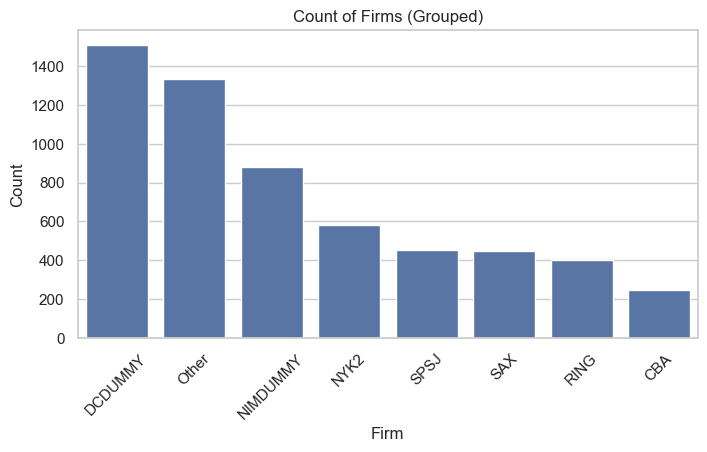

In [108]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='FirmAccount', order=df["FirmAccount"].value_counts().index)
plt.title("Count of Firms (Grouped)")
plt.xlabel("Firm")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


### OHE categorical features

In [109]:
#Not necessarry in Tabular learning as feature is discrete. Instead map unique firms to some index. See below. 

#df_encoded = pd.get_dummies(df, columns=categorical_columns)
#correlation_matrix = df_encoded.corr()
#correlation_matrix
